# Demo 1: Developing a Single Neuron in PyTorch

Understanding neural networks starts with understanding their most basic building block: the single neuron. While modern deep learning involves millions of interconnected neurons, each one performs the same simple computation you are about to implement.

> **Overview**: We'll build our first neural network component—a single neuron (or perceptron)—and see how it computes outputs from inputs using different sets of weights and bias. 
> 
> **Scenario**: Your streaming service currently relies on manual curation of movies that can't scale to thousands of new entries added monthly. You need an automated way to identify which movies deserve promotion based on viewer ratings and popularity metrics. _Can a single neuron learn this decision boundary?_
> 
> **Goal**: Develop hands-on understanding of how a perceptron transforms inputs into outputs, how weights control what patterns matter, and how a single neuron creates linear decision boundaries in data.
> 
> **Tools**: Python, PyTorch, NumPy, Pandas, Matplotlib

## Step 1: Setup

Let's start by importing our core libraries and setting up our computational environment.

In [1]:
# Import core libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory for visualizations
output_dir = 'assets/demo1'
os.makedirs(output_dir, exist_ok=True)

# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("Setup complete!\n")

Using device: cuda
Setup complete!



> **PyTorch and tensors**: PyTorch is one of the most popular deep learning frameworks. The fundamental data structure in PyTorch is the tensor: similar to NumPy arrays, but optimized for neural network operations and GPU acceleration. 
> 
> You can think of tensors as multi-dimensional arrays that can efficiently represent inputs, weights, and outputs of neural networks.

## Step 2: Load and explore the movie dataset

We'll work with a real movie dataset containing ratings and popularity scores. Our goal is to identify which movies are worth promoting to users.

In [2]:
# Load the movies dataset from Hugging Face
print("Loading movie dataset...")
dataset = load_dataset('Pablinho/movies-dataset', split='train')

# Convert to pandas for easier manipulation
df = pd.DataFrame(dataset)

print(f"Total movies in dataset: {len(df):,}")
print(f"\nDataset columns: {df.columns.tolist()}")
print(f"\nFirst few entries:")
df[['Title', 'Vote_Average', 'Popularity']].head()

Loading movie dataset...
Total movies in dataset: 9,837

Dataset columns: ['Release_Date', 'Title', 'Overview', 'Popularity', 'Vote_Count', 'Vote_Average', 'Original_Language', 'Genre', 'Poster_Url']

First few entries:


,Title,Vote_Average,Popularity
0,Spider-Man: No Way Home,8.3,5083.954
1,The Batman,8.1,3827.658
2,No Exit,6.3,2618.087
3,Encanto,7.7,2402.201
4,The King's Man,7.0,1895.511


### Step 2.1: Data Preprocessing

Before we can train our perceptron, we need to clean the data and create labels. This involves handling missing values, filtering invalid entries, normalizing entries, and defining what "promotion-worthy" means. 

**IMPORTANT: Feel free to skip this section to focus on the perceptron itself**. Just know that we end up with 500 movies, each labeled as either "promote" or "don't promote" based on rating and popularity thresholds.

In [3]:
# Clean and prepare the data

# Step 1: Convert Vote_Average to numeric (handles errors like "animation" strings)
df['Vote_Average'] = pd.to_numeric(df['Vote_Average'], errors='coerce')

# Step 2: Filter for valid data (remove missing values and zeros)
df_clean = df[(df['Vote_Average'] > 0) & 
              (df['Popularity'] > 0) & 
              (df['Vote_Average'].notna())].copy()

# Step 3: Sample 500 movies for our analysis, and extract features
df_subset = df_clean.sample(n=500, random_state=42).reset_index(drop=True)

vote_avg = df_subset['Vote_Average'].values  # Rating out of 10
popularity = df_subset['Popularity'].values   # Popularity metric

# Step 4: Normalize features for effective learning
# Formula: x_normalized = (x - min) / (max - min) --> min-max scaling
vote_avg_norm = (vote_avg - vote_avg.min()) / (vote_avg.max() - vote_avg.min())
popularity_norm = (popularity - popularity.min()) / (popularity.max() - popularity.min())

# Step 5: Create binary labels for classification
# Movies worth promoting: high rating (>7.0) AND reasonably popular (>50)
labels = ((vote_avg > 7.0) & (popularity > 50)).astype(int)

print(f"✓ Working with {len(df_subset)} clean movies")
print(f"✓ Filtered out {len(df) - len(df_clean)} movies with invalid data")
print(f"\nFeature ranges:")
print(f"  Rating: {vote_avg.min():.1f} to {vote_avg.max():.1f}")
print(f"  Popularity: {popularity.min():.1f} to {popularity.max():.1f}")
print(f"\nClass distribution:")
print(f"  Promotion-worthy: {labels.sum()} ({labels.sum()/len(labels)*100:.1f}%)")
print(f"  Don't promote: {(1-labels).sum()} ({(1-labels).sum()/len(labels)*100:.1f}%)")

✓ Working with 500 clean movies
✓ Filtered out 111 movies with invalid data

Feature ranges:
  Rating: 2.8 to 8.7
  Popularity: 13.4 to 5084.0

Class distribution:
  Promotion-worthy: 31 (6.2%)
  Don't promote: 469 (93.8%)


> **Preprocessing overview** (optional deep-dive): We performed several standard ML preprocessing steps:
> 1. **Data cleaning**: Converted Vote_Average to numeric, handling errors like "animation" strings
> 2. **Filtering**: Removed movies with missing or zero values
> 3. **Sampling**: Selected 500 movies for efficient visualization
> 4. **Feature normalization**: Scaling features to the same range [0, 1] incentivizes the perceptron to give them the same importance.
> 5. **Label creation**: Defined "promotion-worthy" as rating >7.0 AND popularity >50

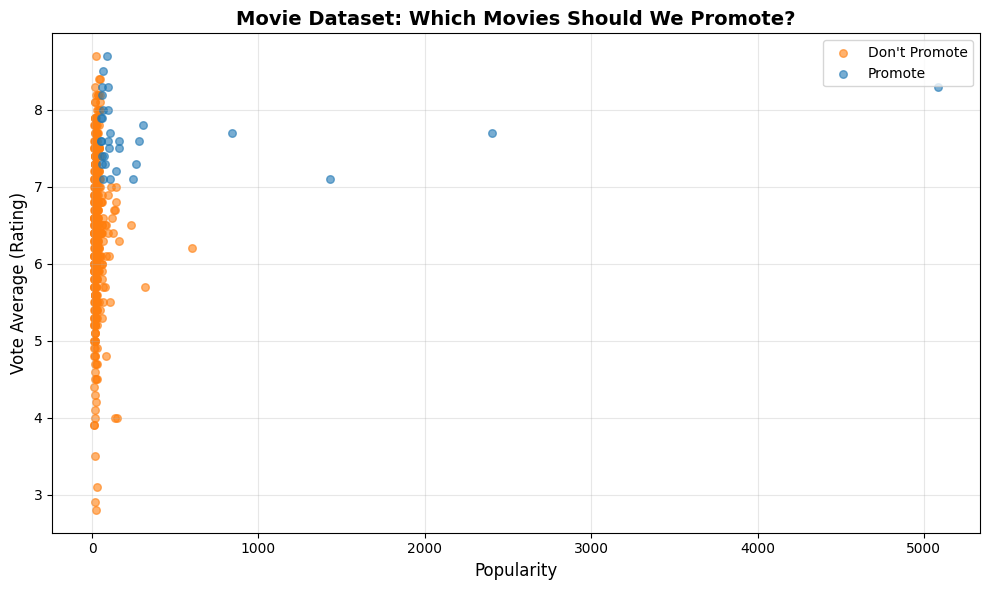

Can a single neuron learn to draw a line that separates them?


In [4]:
# Visualize the data distribution

plt.figure(figsize=(10, 6))
colors = ['#ff7f0e', '#1f77b4']  # Orange for class 0, blue for class 1
labels_text = ['Don\'t Promote', 'Promote']

for i in range(2):
    mask = labels == i
    plt.scatter(popularity[mask], vote_avg[mask], 
                c=colors[i], label=labels_text[i], alpha=0.6, s=30)

plt.xlabel('Popularity', fontsize=12)
plt.ylabel('Vote Average (Rating)', fontsize=12)
plt.title('Movie Dataset: Which Movies Should We Promote?', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'movie_data_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Can a single neuron learn to draw a line that separates them?")

> **Classification task**: This is a binary classification problem where we want to draw a boundary that separates promotion, i.e., worthy movies from others. A single neuron will learn to create a straight line (linear boundary) that best divides these two groups. 
> 
> Notice how the blue points (promote) cluster in the region: our neuron needs to learn weights that capture this pattern.

### Step 2.2  Convert to PyTorch tensors

Before feeding data into our perceptron, we need to convert it to a PyTorch tensor: the data structure neural networks use for computation.

In [5]:
# Stack features into a 2D array: each row is one movie, columns are [rating, popularity]
X = np.column_stack([vote_avg_norm, popularity_norm])

# Create tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(labels)

print(f"Input shape: {X_tensor.shape} (500 movies, 2 features each)")
print(f"Label shape: {y_tensor.shape} (500 binary labels)")
print(f"\nFirst 3 movies:")
print(f"Features (normalized): {X_tensor[:3]}")
print(f"Labels: {y_tensor[:3]}")

Input shape: torch.Size([500, 2]) (500 movies, 2 features each)
Label shape: torch.Size([500]) (500 binary labels)

First 3 movies:
Features (normalized): tensor([[0.5424, 0.0091],
        [0.5254, 0.0019],
        [0.7797, 0.0022]])
Labels: tensor([0., 0., 0.])


## Step 3: Build a simple perceptron

Now we'll implement the perceptron computation: take inputs, apply weights and bias, and produce an output. This is the heart of how a neuron makes decisions.

In [6]:
def perceptron(X, weights, bias):
    """
    Compute perceptron output: z = w₁*x₁ + w₂*x₂ + b
    Then apply step activation: output = 1 if z > 0, else 0
    
    Args:
        X: Input features (N x 2 tensor)
        weights: Weight vector (2 values)
        bias: Bias term (1 value)
    
    Returns:
        predictions: Binary predictions (N values)
    """
    # Compute weighted sum: multiply each input by its weight, then sum
    # This is a dot product: [x₁, x₂] · [w₁, w₂] = x₁*w₁ + x₂*w₂
    z = torch.matmul(X, weights) + bias
    
    # Apply step activation function: output 1 if z > 0, else 0
    predictions = (z > 0).float()
    
    return predictions, z

print("Perceptron function defined!")
print("\nThe perceptron equation: z = w₁*x₁ + w₂*x₂ + b")
print("decision rule: output = 1 if z > 0, else 0")

Perceptron function defined!

The perceptron equation: z = w₁*x₁ + w₂*x₂ + b
decision rule: output = 1 if z > 0, else 0


> **The perceptron equation**: This simple formula—weighted sum plus bias—is the foundation of all neural networks. Each neuron in every deep learning model performs this same core computation. 
> 
> Models learn the right weight and bias values through training. For now, we'll manually set these values to build intuition for what they do.

## Step 4: Test with manual weights

Let's start by manually setting weights to see how they affect our neuron's decisions. This helps build intuition before we learn to train networks automatically.

In [7]:
# Experiment 1: Weight rating only
weights_rating = torch.tensor([1.0, 0.0])  # w₁=1 for rating, w₂=0 for popularity
bias_rating = torch.tensor(-0.7)           # Negative bias makes activation harder

predictions_rating, z_rating = perceptron(X_tensor, weights_rating, bias_rating)
accuracy_rating = (predictions_rating == y_tensor).float().mean()

print("Experiment 1: Rating-Only Decision")
print(f"Weights: rating={weights_rating[0].item():.1f}, popularity={weights_rating[1].item():.1f}")
print(f"Bias: {bias_rating.item():.1f}")
print(f"Accuracy: {accuracy_rating:.1%}")
print(f"\nInterpretation: The neuron only considers rating, ignoring popularity entirely.\n")

Experiment 1: Rating-Only Decision
Weights: rating=1.0, popularity=0.0
Bias: -0.7
Accuracy: 74.8%

Interpretation: The neuron only considers rating, ignoring popularity entirely.



In [8]:
# Experiment 2: Weight popularity only  
weights_popularity = torch.tensor([0.0, 1.0])  # w₁=0 for rating, w₂=1 for popularity
bias_popularity = torch.tensor(-0.5)

predictions_popularity, z_popularity = perceptron(X_tensor, weights_popularity, bias_popularity)
accuracy_popularity = (predictions_popularity == y_tensor).float().mean()

print("Experiment 2: Popularity-Only Decision")
print(f"Weights: rating={weights_popularity[0].item():.1f}, popularity={weights_popularity[1].item():.1f}")
print(f"Bias: {bias_popularity.item():.1f}")
print(f"Accuracy: {accuracy_popularity:.1%}")
print(f"\nInterpretation: The neuron only considers popularity, ignoring rating entirely.\n")

Experiment 2: Popularity-Only Decision
Weights: rating=0.0, popularity=1.0
Bias: -0.5
Accuracy: 94.0%

Interpretation: The neuron only considers popularity, ignoring rating entirely.



In [9]:
# Experiment 3: Balance both features
weights_balanced = torch.tensor([0.6, 0.8])  # Weight both features, popularity slightly more
bias_balanced = torch.tensor(-0.8)

predictions_balanced, z_balanced = perceptron(X_tensor, weights_balanced, bias_balanced)
accuracy_balanced = (predictions_balanced == y_tensor).float().mean()

print("Experiment 3: Balanced Decision")
print(f"Weights: rating={weights_balanced[0].item():.1f}, popularity={weights_balanced[1].item():.1f}")
print(f"Bias: {bias_balanced.item():.1f}")
print(f"Accuracy: {accuracy_balanced:.1%}")
print(f"\nInterpretation: The neuron considers both features, with popularity weighted slightly higher.\n")
print("Notice how balancing both features gives us better accuracy!")

Experiment 3: Balanced Decision
Weights: rating=0.6, popularity=0.8
Bias: -0.8
Accuracy: 94.2%

Interpretation: The neuron considers both features, with popularity weighted slightly higher.

Notice how balancing both features gives us better accuracy!


> **Weights as feature importance**: When we set weight=1 for rating and weight=0 for popularity, the neuron completely ignores popularity. When we balance both weights, the neuron considers both features in its decision. This is how neurons learn what matters: through training, weights automatically adjust to capture the patterns that best predict the output. 
> 
> Large weights mean "this feature is important"; weights near zero mean "ignore this feature."

## Step 5: Visualize decision boundaries

The real power of understanding perceptrons comes from visualizing what they learn. A decision boundary is the line the neuron draws to separate the two classes.

In [10]:
def plot_decision_boundary(X, y, weights, bias, title, filename=None):
    """
    Plot data points and the decision boundary learned by the perceptron.
    
    The decision boundary is where z = w₁*x₁ + w₂*x₂ + b = 0
    Rearranging: x₂ = -(w₁*x₁ + b) / w₂
    """
    plt.figure(figsize=(10, 6))
    
    # Plot data points
    colors = ['#ff7f0e', '#1f77b4']
    labels_text = ['Don\'t Promote', 'Promote']
    
    for i in range(2):
        mask = y == i
        plt.scatter(X[mask, 1], X[mask, 0], 
                    c=colors[i], label=labels_text[i], alpha=0.6, s=30)
    
    # Plot decision boundary
    x1_range = np.array([0, 1])
    
    # Check if w₂ is not zero to avoid division by zero
    if abs(weights[1]) > 1e-6:
        # Decision boundary equation: x₂ = -(w₁*x₁ + b) / w₂
        x2_boundary = -(weights[0] * x1_range + bias) / weights[1]
        plt.plot(x1_range, x2_boundary, 'r-', linewidth=2, label='Decision Boundary')
    else:
        # Vertical line when w₂ ≈ 0: x₁ = -b/w₁
        if abs(weights[0]) > 1e-6:
            x1_boundary = -bias / weights[0]
            plt.axvline(x=x1_boundary, color='r', linewidth=2, label='Decision Boundary')
    
    plt.xlabel('Popularity (normalized)', fontsize=12)
    plt.ylabel('Rating (normalized)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    
    if filename:
        plt.savefig(os.path.join(output_dir, filename), dpi=300, bbox_inches='tight')
    
    plt.show()

print("Visualization function defined!")

Visualization function defined!


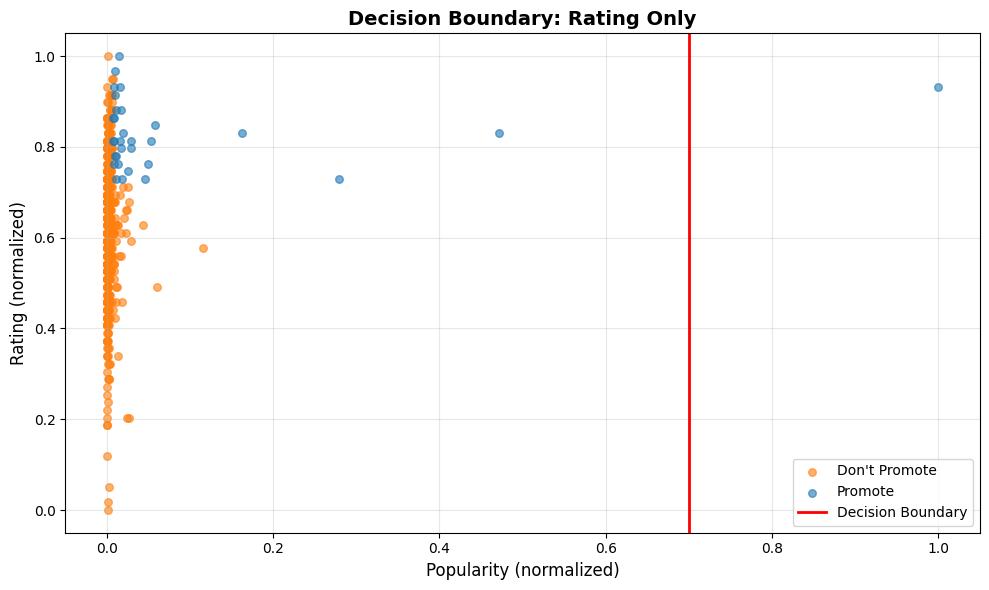

In [11]:
# Visualize all three experiments
plot_decision_boundary(X, labels, weights_rating.numpy(), bias_rating.item(),
                       'Decision Boundary: Rating Only',
                       'boundary_rating_only.png')

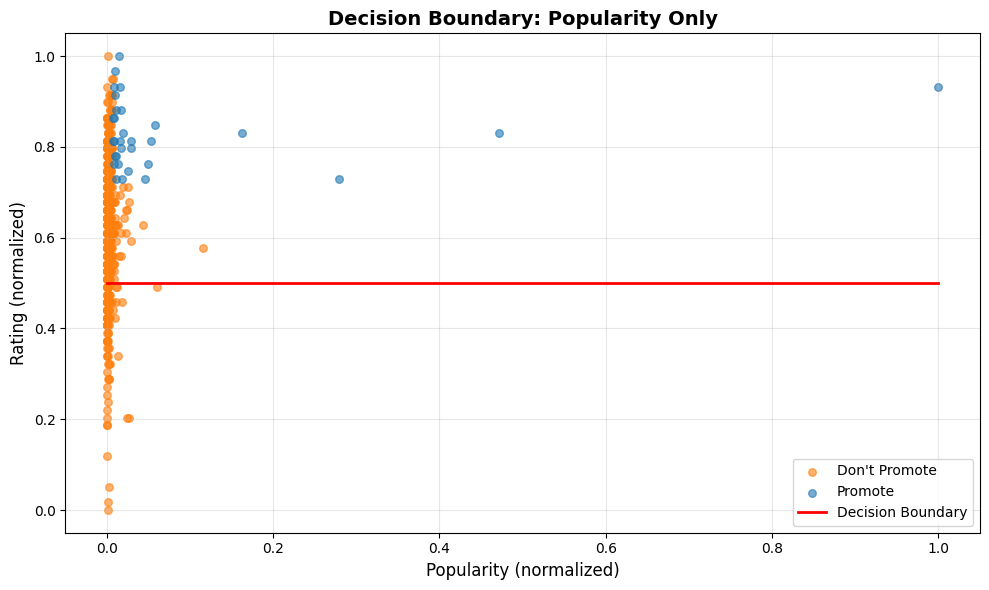

In [12]:
plot_decision_boundary(X, labels, weights_popularity.numpy(), bias_popularity.item(),
                       'Decision Boundary: Popularity Only',
                       'boundary_popularity_only.png')

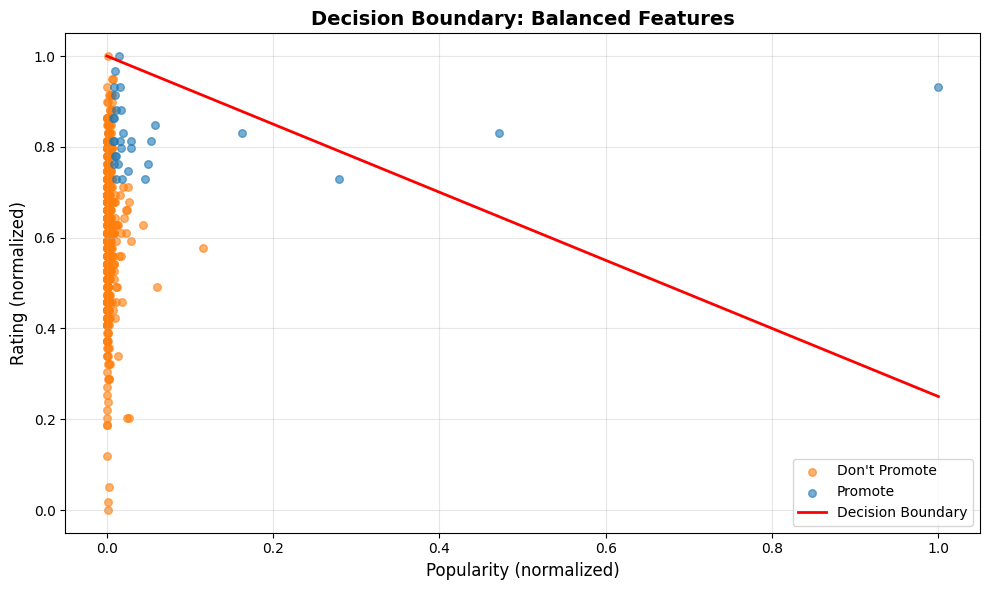

In [13]:
plot_decision_boundary(X, labels, weights_balanced.numpy(), bias_balanced.item(),
                       'Decision Boundary: Balanced Features',
                       'boundary_balanced.png')

> **Decision boundaries as lines**: Notice how each set of weights creates a different straight line through the data. This is the fundamental characteristic of a single-layer perceptron: it can only create linear (straight) boundaries.
> - When we weight only rating, we get a horizontal line. 
> - When we weight only popularity, we get a vertical line. 
> - When we balance both, we get a diagonal line. 
> 
> The neuron is trying to draw a line that best separates the two classes (but it's always just one straight line!).

## Step 6: Explore different patterns visually

Let's create a comprehensive visualization showing how different weight combinations create different decision boundaries.

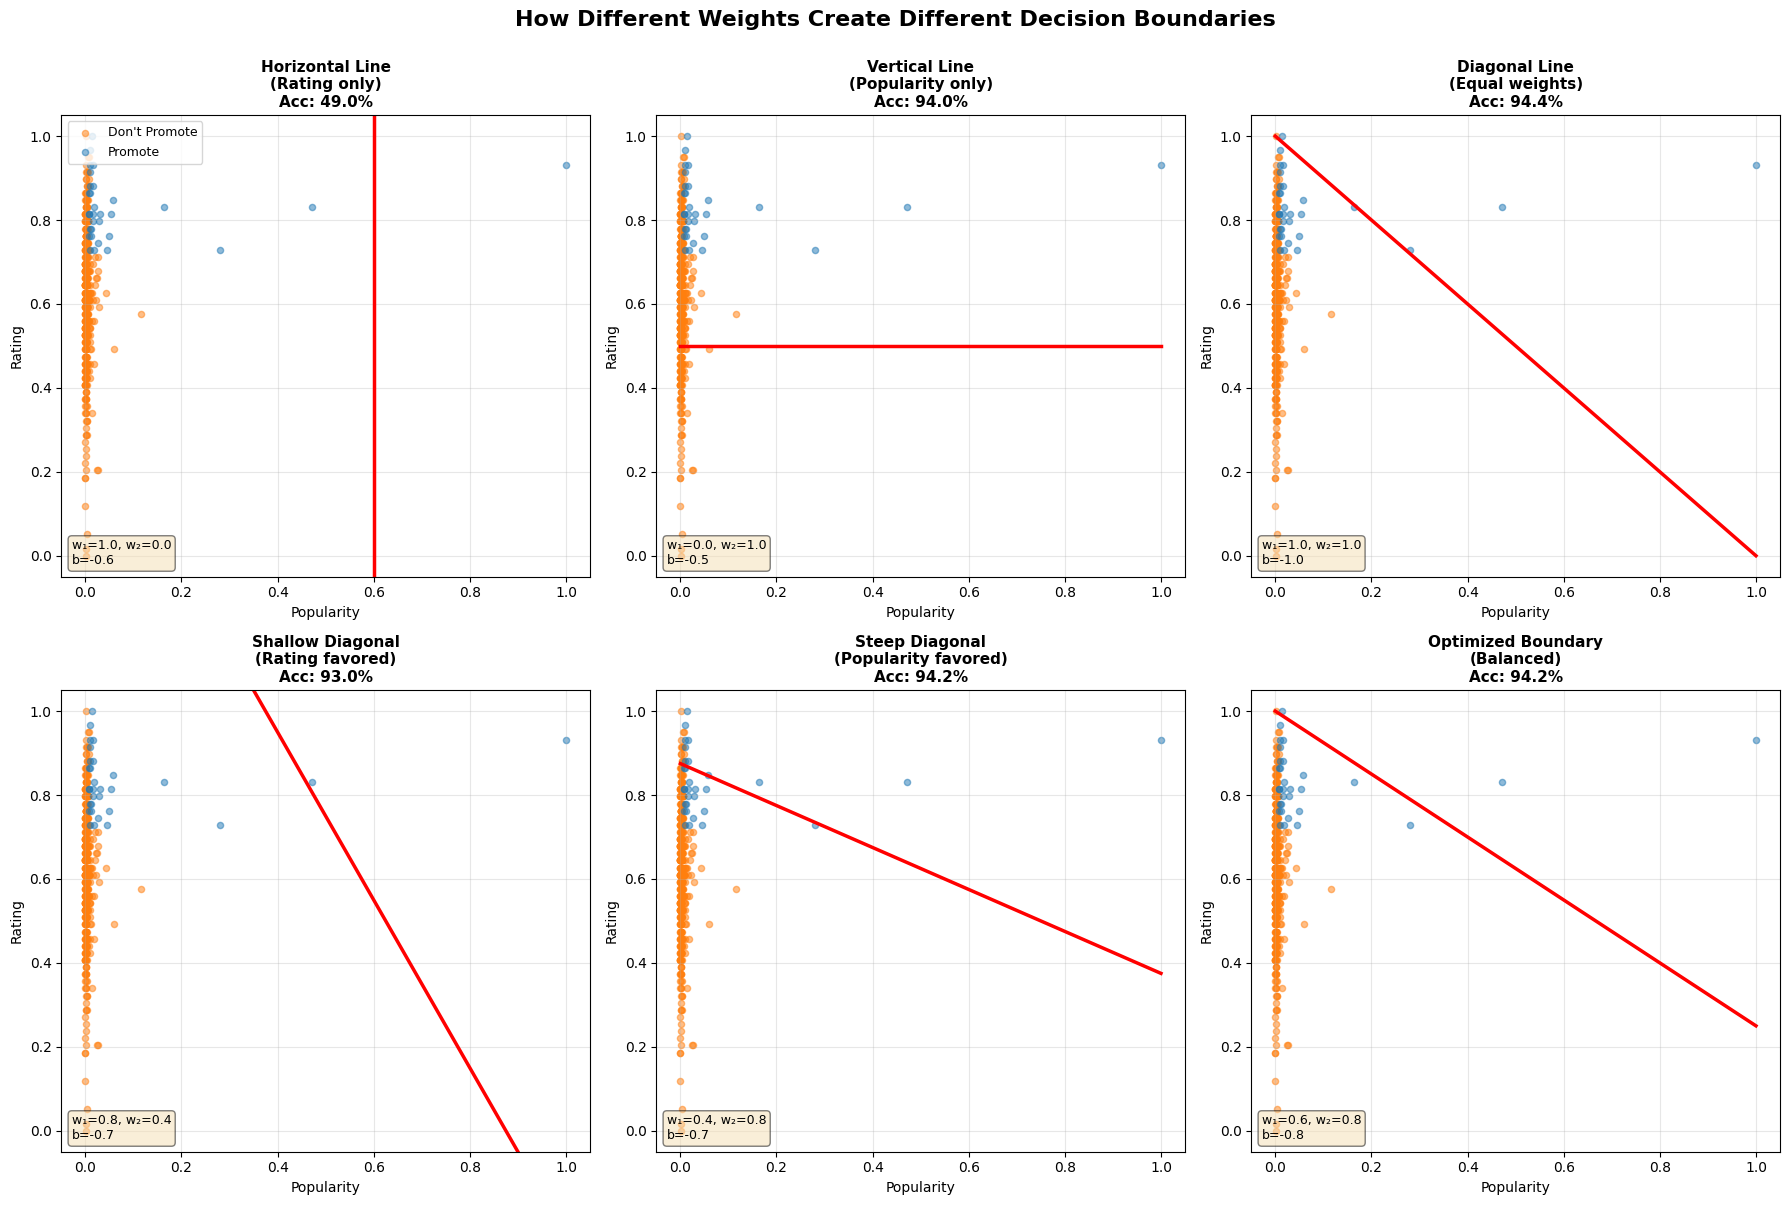


Key observations:
• Horizontal lines: Neuron only considers rating (w₂=0)
• Vertical lines: Neuron only considers popularity (w₁=0)
• Diagonal lines: Neuron balances both features
• The slope of the line depends on the ratio w₁/w₂
• The position of the line is controlled by the bias
• All boundaries are straight lines—single neurons can't create curves!


In [14]:
# Create a figure with multiple decision boundaries
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Different weight configurations to explore
configurations = [
    {'weights': [1.0, 0.0], 'bias': -0.6, 'title': 'Horizontal Line\n(Rating only)'},
    {'weights': [0.0, 1.0], 'bias': -0.5, 'title': 'Vertical Line\n(Popularity only)'},
    {'weights': [1.0, 1.0], 'bias': -1.0, 'title': 'Diagonal Line\n(Equal weights)'},
    {'weights': [0.8, 0.4], 'bias': -0.7, 'title': 'Shallow Diagonal\n(Rating favored)'},
    {'weights': [0.4, 0.8], 'bias': -0.7, 'title': 'Steep Diagonal\n(Popularity favored)'},
    {'weights': [0.6, 0.8], 'bias': -0.8, 'title': 'Optimized Boundary\n(Balanced)'}
]

colors = ['#ff7f0e', '#1f77b4']
labels_text = ['Don\'t Promote', 'Promote']

for idx, config in enumerate(configurations):
    ax = axes[idx]
    
    weights = np.array(config['weights'])
    bias = config['bias']
    
    # Plot data points
    for i in range(2):
        mask = labels == i
        ax.scatter(X[mask, 1], X[mask, 0], 
                   c=colors[i], label=labels_text[i] if idx == 0 else '', 
                   alpha=0.5, s=20)
    
    # Plot decision boundary
    x1_range = np.array([0, 1])
    if abs(weights[1]) > 1e-6:
        x2_boundary = -(weights[0] * x1_range + bias) / weights[1]
        ax.plot(x1_range, x2_boundary, 'r-', linewidth=2.5)
    else:
        if abs(weights[0]) > 1e-6:
            x1_boundary = -bias / weights[0]
            ax.axvline(x=x1_boundary, color='r', linewidth=2.5)
    
    # Calculate accuracy
    w_tensor = torch.FloatTensor(weights)
    b_tensor = torch.FloatTensor([bias])
    preds, _ = perceptron(X_tensor, w_tensor, b_tensor)
    acc = (preds == y_tensor).float().mean().item()
    
    ax.set_xlabel('Popularity', fontsize=10)
    ax.set_ylabel('Rating', fontsize=10)
    ax.set_title(f"{config['title']}\nAcc: {acc:.1%}", fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    
    if idx == 0:
        ax.legend(loc='upper left', fontsize=9)
    
    # Add weight information
    weight_text = f"w₁={weights[0]:.1f}, w₂={weights[1]:.1f}\nb={bias:.1f}"
    ax.text(0.02, 0.02, weight_text, transform=ax.transAxes, 
            fontsize=9, verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('How Different Weights Create Different Decision Boundaries', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'decision_boundaries_comparison.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

print("\nKey observations:")
print("• Horizontal lines: Neuron only considers rating (w₂=0)")
print("• Vertical lines: Neuron only considers popularity (w₁=0)")
print("• Diagonal lines: Neuron balances both features")
print("• The slope of the line depends on the ratio w₁/w₂")
print("• The position of the line is controlled by the bias")
print("• All boundaries are straight lines—single neurons can't create curves!")

> **The geometry of weights**: The weights don't just determine importance: they define the geometry of the decision boundary. The ratio w₁/w₂ determines the slope of the line, while the bias shifts it left/right or up/down. This geometric interpretation helps explain why single neurons are limited: they can only draw straight lines. 
> 
> For more complex patterns, we'll need to find a way to create curved boundaries (spoiler alert: through multiple layers with non-linear decision rules!).

## Conclusion

Congratulations! You've built and explored your first neural network component, the perceptron. Every neuron in every deep neural network, from image classifiers to language models, performs this same basic computation. 

Let's recap what you've discovered:

1. **The perceptron equation**: `z = w₁*x₁ + w₂*x₂ + b` followed by a step activation
2. **Weights as importance**: Larger weights mean the neuron pays more attention to that feature
3. **Bias as threshold**: The bias shifts when the neuron activates
4. **Decision boundaries**: A single neuron creates a linear (straight) boundary through the data
5. **The fundamental limitation**: Single neurons can only solve linearly separable problems

> **Key insight:** Different weight combinations create different boundary orientations; balancing them appropriately leads to better classification accuracy.

##### Next steps to explore:

- [ ] **Add more features**: What if we included movie runtime as a third input? 
<br>_The perceptron equation extends naturally: `z = w₁*rating + w₂*popularity + w₃*runtime + b`. The decision boundary becomes a 2D plane in 3D space instead of a line in 2D!_
<br><br>
- [ ] **Get confidence scores**: Right now, our step function outputs only 0 or 1. But what if we want to know *how confident* the neuron is? Should we promote a movie that barely crosses the threshold the same as one that strongly exceeds it? 